In [2]:
#imports
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from collections import Counter

from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import models
from keras import layers
from keras import regularizers

from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [3]:
#reading critical dataset 
critical = pd.read_csv("sample_data/critical-findings-sample-data.csv",encoding = 'utf-8')
#reading non-critical dataset
non_critical = pd.read_csv("sample_data/non-critical-findings-sample-data.csv",encoding = 'utf-8')

In [4]:
#replacing None with No critical Finding
non_critical['Critical_Finding'] = non_critical['Critical_Finding'].replace(regex='None', value='No Critical Finding')

#replacing NaN with No Category
non_critical['Category'] = 'No Category'


In [5]:
#merging critical and non-critical datasets
merged_df = pd.concat([critical,non_critical])

#restting index after merge
merged_df=merged_df.reset_index(drop=True) 

In [6]:
#converts the data column to lower case
merged_df['Data'] = merged_df['Data'].astype(str).str.lower()

#since xray is found in glove replacing x-ray with xray
merged_df['Data'] = merged_df['Data'].str.replace('x-ray','xray') 

#html tags replace
tag_replace = '<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6})' 
merged_df['Data'] = merged_df['Data'].str.replace(tag_replace, ' ') 

#replacing punctuations with whitespace
pattern = '[!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~]'
merged_df['Data'] = merged_df['Data'].str.replace(pattern, ' ')            

#numbers removal
merged_df['Data'] = merged_df['Data'].replace('\d+', '', regex=True) 

#replaces many spaces with a single space
merged_df['Data'] = merged_df['Data'].replace('\s+', ' ', regex=True)

merged_df['Data'][0]

'study ct chest with contrast reason for exam male years old chest pain and esophageal dilation radiation dosage if supplied by facility ctdivol mgy dlp mgycm technique transaxial imaging was performed following intravenous administration of ml ml of isovue contrast material individualized dose optimization techniques were used for this ct comparison none findings the lungs are normal there is no demonstrated pleural abnormality normal heart and pericardium normal mediastinum normal hilar regions pulmonary emboli are present in right lower lobe arterial branches normal aorta arch and descending thoracic aorta normal osseous structures there is no demonstrated abnormality of the visualized upper abdomen impression pulmonary emboli are present in right lower lobe arterial branches no evidence of acute pulmonary or mediastinal pathology '

In [7]:
#Taking out the feature and label columns
final_df = merged_df[['Data', 'Critical_Finding']]

In [8]:
#splitting the dataset into train dataset and test dataset
X_train, X_test, y_train, y_test = train_test_split(final_df.Data, final_df.Critical_Finding, test_size=0.3, random_state=37)
print(' Train data samples:', X_train.shape[0])
print(' Test data samples:', X_test.shape[0])
assert X_train.shape[0] == y_train.shape[0]
assert X_test.shape[0] == y_test.shape[0]

 Train data samples: 700
 Test data samples: 300


In [9]:
#max words to be put into the dictionary
MAX_WORDS = 3200

#keras tokenizer for tokenizing then data
tk = Tokenizer(num_words=MAX_WORDS,
               filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
               lower=True,
               split=" ")

tk.fit_on_texts(X_train)

#converting the texts to sequences
X_train_seq = tk.texts_to_sequences(X_train)
X_test_seq = tk.texts_to_sequences(X_test)

X_train_seq

[[149,
  124,
  28,
  70,
  316,
  906,
  866,
  23,
  21,
  162,
  4,
  114,
  298,
  3,
  1,
  28,
  20,
  61,
  18,
  1,
  390,
  4,
  468,
  1881,
  8,
  2,
  1,
  163,
  8,
  167,
  6,
  5,
  7,
  246,
  26,
  108,
  183,
  1882,
  520,
  49,
  8,
  65,
  6,
  157,
  19,
  126,
  376,
  262,
  150,
  567,
  1,
  9,
  631,
  949,
  503,
  19,
  665,
  700,
  22,
  7,
  42,
  568,
  74,
  15,
  1,
  28,
  6,
  157,
  19,
  126,
  376,
  262,
  150,
  567,
  1,
  9,
  631,
  949,
  503,
  19,
  665,
  700,
  217,
  103,
  32,
  441,
  442,
  106,
  55,
  38,
  214,
  4,
  103,
  32,
  441,
  442,
  106],
 [25,
  16,
  50,
  4,
  83,
  10,
  17,
  31,
  11,
  27,
  64,
  34,
  29,
  50,
  81,
  153,
  73,
  90,
  67,
  91,
  32,
  92,
  100,
  101,
  94,
  95,
  21,
  96,
  36,
  20,
  102,
  77,
  1,
  215,
  3,
  1,
  194,
  19,
  1,
  225,
  226,
  24,
  176,
  17,
  139,
  3,
  263,
  17,
  40,
  317,
  118,
  4,
  120,
  36,
  20,
  159,
  53,
  44,
  45,
  54,
  20,
  47,
  11,


In [10]:
#Finding out the maximum sequence length 
seq_lengths = X_train.apply(lambda x: len(x.split(' ')))
seq_lengths.describe()

count    700.000000
mean     170.062857
std      102.282892
min        3.000000
25%       97.000000
50%      147.000000
75%      224.250000
max      737.000000
Name: Data, dtype: float64

In [11]:
#since the maximum size of a sequence is 737, padding all other sequnces to change them to equal length
MAX_LEN = 737
X_train_seq_trunc = pad_sequences(X_train_seq, maxlen=MAX_LEN)
X_test_seq_trunc = pad_sequences(X_test_seq, maxlen=MAX_LEN)

In [12]:
X_train_seq_trunc[10]  

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   

In [13]:
#encoding the label into numbers
le = LabelEncoder()
y_train_le = le.fit_transform(y_train)
y_test_le = le.transform(y_test)
y_train_oh = to_categorical(y_train_le)
y_test_oh = to_categorical(y_test_le)


In [14]:
#splitting the modified features and labels into train and test 
X_train_emb, X_valid_emb, y_train_emb, y_valid_emb = train_test_split(X_train_seq_trunc, y_train_oh, test_size=0.1, random_state=37)

assert X_valid_emb.shape[0] == y_valid_emb.shape[0]
assert X_train_emb.shape[0] == y_train_emb.shape[0]

print('Shape of validation set:',X_valid_emb.shape)

Shape of validation set: (70, 737)


In [15]:
#reading glove file and putting the words and their embeddings into  dictionary
glove_file = 'glove.txt'
emb_dict = {}
glove = open(glove_file,'r',encoding="utf8")
for line in glove:
    values = line.split()
    word = values[0]
    vector = np.asarray(values[1:], dtype='float32')
    emb_dict[word] = vector
glove.close()

In [16]:
GLOVE_DIM = 300
emb_matrix = np.zeros((MAX_WORDS, GLOVE_DIM))

#Replacing words present in the corpus with corresponding embeddings
for w, i in tk.word_index.items():
    # The word_index contains a token for all words of the training data so we need to limit that
    if i < MAX_WORDS:
        vect = emb_dict.get(w)
        # Check if the word from the training data occurs in the GloVe word embeddings
        # Otherwise the vector is kept with only zeros
        if vect is not None:
            emb_matrix[i] = vect
    else:
        break

In [17]:
#creating sequential model
glove_model = models.Sequential()
#adding embedding layer
glove_model.add(layers.Embedding(MAX_WORDS, GLOVE_DIM, input_length=MAX_LEN))
#flattening the embedding layer
glove_model.add(layers.Flatten())
#Adding dense layer
glove_model.add(layers.Dense(3, activation='softmax'))
glove_model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 737, 300)          960000    
_________________________________________________________________
flatten_1 (Flatten)          (None, 221100)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 663303    
Total params: 1,623,303
Trainable params: 1,623,303
Non-trainable params: 0
_________________________________________________________________


In [18]:
#adding the embeddign matrix calculated from the corpus
glove_model.layers[0].set_weights([emb_matrix])
glove_model.layers[0].trainable = False

In [19]:
#function for compiling and fitting the model provided
def deep_model(model, X_train, y_train, X_valid, y_valid):
    '''
    Function to train a multi-class model.
    
    Parameters:
        model : model with the chosen architecture
        X_train : training features
        y_train : training target
        X_valid : validation features
        Y_valid : validation target
    Output:
        model training history
    '''
    model.compile(optimizer='rmsprop'
                  , loss='categorical_crossentropy'
                  , metrics=['accuracy'])
    
    history = model.fit(X_train
                       , y_train
                       , epochs=50
                       , batch_size=BATCH_SIZE
                       , validation_data=(X_valid, y_valid)
                       , verbose=0)
    return history,model


In [20]:
BATCH_SIZE = 512
glove_history, model_glove = deep_model(glove_model, X_train_emb, y_train_emb, X_valid_emb, y_valid_emb)
glove_history.history['acc'][-1]
#printing the validation accuracy

Instructions for updating:
Use tf.cast instead.


0.9984126984126984

In [21]:
print(model_glove.evaluate(X_valid_emb,y_valid_emb))
#The final accuracy is 88%

70/70 [==============================] - 0s 276us/step
[0.2808164600815092, 0.8714285697255816]


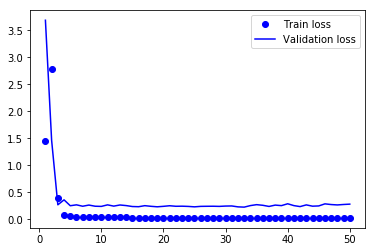

In [24]:
def eval_metric(history, metric_name):
    '''
    Function to evaluate a trained model on a chosen metric. 
    Training and validation metric are plotted in a
    line chart for each epoch.
    
    Parameters:
        history : model training history
        metric_name : loss or accuracy
    Output:
        line chart with epochs of x-axis and metric on
        y-axis
    '''
    metric = history.history[metric_name]
    val_metric = history.history['val_' + metric_name]

    e = range(1, 50 + 1)

    plt.plot(e, metric, 'bo', label='Train ' + metric_name)
    plt.plot(e, val_metric, 'b', label='Validation ' + metric_name)
    plt.legend()
    plt.show()

eval_metric(glove_history, 'loss')


# CNN model

In [29]:
cnn_model  = models.Sequential()
# Add the word embedding Layer
cnn_model.add(layers.Embedding( MAX_WORDS, 300,input_length = MAX_LEN, weights=[emb_matrix], trainable=False))
cnn_model.add(layers.SpatialDropout1D(0.3))

# Add the convolutional Layer
cnn_model.add( layers.Convolution1D(100, 3, activation="relu"))

# Add the pooling Layer
cnn_model.add( layers.GlobalMaxPool1D())

# Add the output Layers
cnn_model.add( layers.Dense(50, activation="relu"))
cnn_model.add( layers.Dropout(0.25))
cnn_model.add(layers.Dense(3, activation="sigmoid"))

cnn_model.summary()

# VAL_SIZE = 1000  # Size of the validation set
NB_START_EPOCHS = 20 # Number of epochs we usually start to train with
BATCH_SIZE = 512
glove_history, model_glove = deep_model(cnn_model, X_train_emb, y_train_emb, X_valid_emb, y_valid_emb)
glove_history.history['acc'][-1]
print(model_glove.evaluate(X_valid_emb,y_valid_emb))


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 737, 300)          960000    
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 737, 300)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 735, 100)          90100     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 100)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 50)                5050      
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 153       
Total para

# RNN

In [31]:
rnn_model  = models.Sequential()
# Add the word embedding Layer
rnn_model.add(layers.Embedding( MAX_WORDS, 300,input_length = MAX_LEN, weights=[emb_matrix], trainable=False))
rnn_model.add(layers.SpatialDropout1D(0.3))

# Add the LSTM Layer
rnn_model.add( layers.LSTM(100))


# Add the output Layers
rnn_model.add( layers.Dense(50, activation="relu"))
rnn_model.add( layers.Dropout(0.25))
rnn_model.add(layers.Dense(3, activation="sigmoid"))

rnn_model.summary()
rnn_history, model_rnn = deep_model(rnn_model, X_train_emb, y_train_emb, X_valid_emb, y_valid_emb)
rnn_history.history['acc'][-1]
print("Accuracy", model_rnn.evaluate(X_valid_emb,y_valid_emb)[1])


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 737, 300)          960000    
_________________________________________________________________
spatial_dropout1d_4 (Spatial (None, 737, 300)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dense_8 (Dense)              (None, 50)                5050      
_________________________________________________________________
dropout_4 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 3)                 153       
Total params: 1,125,603
Trainable params: 165,603
Non-trainable params: 960,000
______________________________________________________________

# RNN - GRU

In [33]:
GRU_model  = models.Sequential()
# Add the word embedding Layer
GRU_model.add(layers.Embedding( MAX_WORDS, 300,input_length = MAX_LEN, weights=[emb_matrix], trainable=False))
GRU_model.add(layers.SpatialDropout1D(0.3))

# Add the GRU Layer
GRU_model.add( layers.GRU(100))


# Add the output Layers
GRU_model.add( layers.Dense(50, activation="relu"))
GRU_model.add( layers.Dropout(0.25))
GRU_model.add(layers.Dense(3, activation="sigmoid"))

GRU_model.summary()
GRU_history, model_GRU = deep_model(GRU_model, X_train_emb, y_train_emb, X_valid_emb, y_valid_emb)
GRU_history.history['acc'][-1]
print("Accuracy", model_GRU.evaluate(X_valid_emb,y_valid_emb)[1])


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 737, 300)          960000    
_________________________________________________________________
spatial_dropout1d_6 (Spatial (None, 737, 300)          0         
_________________________________________________________________
gru_2 (GRU)                  (None, 100)               120300    
_________________________________________________________________
dense_12 (Dense)             (None, 50)                5050      
_________________________________________________________________
dropout_6 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 3)                 153       
Total params: 1,085,503
Trainable params: 125,503
Non-trainable params: 960,000
______________________________________________________________

# Bi-directional RNN

In [34]:
bi_rnn_model  = models.Sequential()
# Add the word embedding Layer
bi_rnn_model.add(layers.Embedding( MAX_WORDS, 300,input_length = MAX_LEN, weights=[emb_matrix], trainable=False))
bi_rnn_model.add(layers.SpatialDropout1D(0.3))

# Add the Bi-direcional RNN Layer
bi_rnn_model.add( layers.Bidirectional(layers.GRU(100)))


# Add the output Layers
bi_rnn_model.add( layers.Dense(50, activation="relu"))
bi_rnn_model.add( layers.Dropout(0.25))
bi_rnn_model.add(layers.Dense(3, activation="sigmoid"))

bi_rnn_model.summary()
bi_rnn_history, model_bi_rnn = deep_model(bi_rnn_model, X_train_emb, y_train_emb, X_valid_emb, y_valid_emb)
bi_rnn_history.history['acc'][-1]
print("Accuracy", model_bi_rnn.evaluate(X_valid_emb,y_valid_emb)[1])


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 737, 300)          960000    
_________________________________________________________________
spatial_dropout1d_7 (Spatial (None, 737, 300)          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 200)               240600    
_________________________________________________________________
dense_14 (Dense)             (None, 50)                10050     
_________________________________________________________________
dropout_7 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 3)                 153       
Total params: 1,210,803
Trainable params: 250,803
Non-trainable params: 960,000
______________________________________________________________

# Recurrent CNN

In [35]:
rcnn_model  = models.Sequential()
# Add the word embedding Layer
rcnn_model.add(layers.Embedding( MAX_WORDS, 300,input_length = MAX_LEN, weights=[emb_matrix], trainable=False))
rcnn_model.add(layers.SpatialDropout1D(0.3))

# Add the Bi-direcional RNN Layer
rcnn_model.add( layers.Bidirectional(layers.GRU(50, return_sequences=True)))

    
# Add the convolutional Layer
rcnn_model.add(layers.Convolution1D(100, 3, activation="relu"))

# Add the pooling Layer
rcnn_model.add(layers.GlobalMaxPool1D())


# Add the output Layers
rcnn_model.add( layers.Dense(50, activation="relu"))
rcnn_model.add( layers.Dropout(0.25))
rcnn_model.add(layers.Dense(3, activation="sigmoid"))

rcnn_model.summary()
rcnn_history, model_rcnn = deep_model(rcnn_model, X_train_emb, y_train_emb, X_valid_emb, y_valid_emb)
rcnn_history.history['acc'][-1]
print("Accuracy", model_rcnn.evaluate(X_valid_emb,y_valid_emb)[1])


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 737, 300)          960000    
_________________________________________________________________
spatial_dropout1d_8 (Spatial (None, 737, 300)          0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 737, 100)          105300    
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 735, 100)          30100     
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 100)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 50)                5050      
_________________________________________________________________
dropout_8 (Dropout)          (None, 50)                0         
__________